In [5]:
import torch

from torch.utils.data import DataLoader, TensorDataset

from models.VariationalSNLDS import VariationalSNLDS
from models.FlowSNLDS2 import FlowSNLDS
from models.NeuralMSM import NeuralMSM
from dataloaders.BouncingBallDataLoader import BouncingBallDataLoader

from scipy.optimize import linear_sum_assignment
from torch.distributions import Categorical
import numpy as np
import matplotlib.pyplot as plt


In [81]:
images = True
if images:
    pre_train_check = 10
    init_temperature = 10
    iter_update_temp = 50
    iter_check_temp = 200
    epoch_num = 200
    learning_rate = 5e-4
    gamma_decay = 0.8
    scheduler_epochs = 80
    decay_rate = 0.975
else:           
    pre_train_check = 0
    init_temperature = 1
    iter_update_temp = 50
    iter_check_temp = 1000
    epoch_num = 100
    learning_rate = 1e-4
    gamma_decay = 0.5
    scheduler_epochs = 40
    decay_rate = 0.9
dim_obs = 2
dim_latent = 2
num_states = 3
resolution = 16
device = 'cuda:0'
MODEL_PATH = 'results/models_sds/inferred_params_N_5000_T_200_dim_latent_2_dim_obs_2_state_3_sparsity_0.0_net_cosine_seed_24_best_model.pth copy.tar'
OBS_PATH = 'data/latent_variables/obs_test_N_500_T_200_dim_latent_2_dim_obs_2_state_3_sparsity_0.0_net_cosine_seed_24.npy'
STATES_PATH = 'data/latent_variables/states_test_N_500_T_200_dim_latent_2_dim_obs_2_state_3_sparsity_0.0_net_cosine_seed_24.npy'
IMG_MODEL_PATH = 'results/models_sds/inferred_params_images_N_5000_T_100_dim_latent_2_resolution_16_state_3_sparsity_0.0_net_cosine_seed_24_bestflow.pth.tar'
IMG_OBS_PATH = 'data/latent_variables/images_test_N_500_T_100_dim_latent_2_dim_obs_2_resolution_16_state_3_sparsity_0.0_net_cosine_seed_24'
IMG_STATES_PATH = 'data/latent_variables/states_test_N_500_T_100_dim_latent_2_dim_obs_2_state_3_sparsity_0.0_net_cosine_seed_24.npy'



In [97]:
if images:
    dl = BouncingBallDataLoader(IMG_OBS_PATH)
    dataloader = DataLoader(dl, batch_size=1, shuffle=False)
    states = np.load(IMG_STATES_PATH)
    states_dataset = TensorDataset(torch.from_numpy(states).float())
else:
    obs = np.load(OBS_PATH)
    obs_dataset = TensorDataset(torch.from_numpy(obs).float())
    states = np.load(STATES_PATH)
    states_dataset = TensorDataset(torch.from_numpy(states).float())

AttributeError: 'BouncingBallDataLoader' object has no attribute 'numpy'

In [86]:
sample_num = 5

In [110]:
sample = torch.from_numpy(dl[sample_num][0]).float().unsqueeze(0).to(device)
sample.shape

torch.Size([1, 100, 3, 16, 16])

In [158]:
state_sample = states_dataset[sample_num][0].to(device).reshape(1,100)

In [64]:
model = FlowSNLDS(dim_obs, dim_latent, hidden_dim=16, num_states=num_states, encoder_type='video' if images else 'factored', device=device, annealing=True, inference='alpha').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)



model.eval()

FlowSNLDS(
  (transitions): ModuleList(
    (0-2): 3 x MLP(
      (fc_1): Linear(in_features=2, out_features=16, bias=True)
      (fc_2): Linear(in_features=16, out_features=16, bias=True)
      (fc_out): Linear(in_features=16, out_features=2, bias=True)
    )
  )
  (encoder): Glow(
    (preprocess): Preprocess()
    (flow_layers): ModuleList(
      (0): FlowBlock(
        (flow_steps): ModuleList(
          (0-15): 16 x FlowStep(
            (layers): ModuleList(
              (0): Actnorm()
              (1): Inv1x1Conv()
              (2): AffineCoupling(
                (net): ConvBlock(
                  (net): Sequential(
                    (0): WeightNormConv2d(
                      (conv): Conv2d(6, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                    )
                    (1): ReLU()
                    (2): WeightNormConv2d(
                      (conv): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
                    )
                    (3):

In [16]:
# model  = VariationalSNLDS(dim_obs, dim_latent, 64, num_states, encoder_type='recurent', device=device, annealing=True, inference='alpha', beta=1)
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)



# model.eval()

In [17]:
# best_model = NeuralMSM(num_states, dim_latent, hid_dim=16, device=device, lr=7e-3, causal=False, l1_penalty=0, l2_penalty=0, activation='cos') # should be softplus
# model.transitions = best_model.transitions.to(device)
# model.Q = torch.nn.Parameter(best_model.Q.log()).to(device)
# model.pi = torch.nn.Parameter(best_model.pi.log().to(device))
# model.init_cov = torch.nn.Parameter(best_model.init_cov.to(device))
# model.init_mean = torch.nn.Parameter(best_model.init_mean.to(device))

In [18]:
# print(sample)

In [67]:
with torch.no_grad():
    model(sample)

In [66]:
checkpoint = torch.load(IMG_MODEL_PATH)
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [21]:
# def viterbi_sequence(model, input, seq_len=None):
#     (B, T, *_) = input.size()
#     if seq_len is None:
#         seq_len = T
#     z_sample, _ = model._encode_obs(input)
#     z_sample = z_sample.reshape(B,T,-1)
#     log_evidence = model._compute_local_evidence(z_sample)
    
#     delta = torch.zeros_like(log_evidence)
#     psi = torch.zeros(B, T, model.num_states, dtype=torch.long)
#     state_sequence = torch.zeros(B,T)
    
    
#     delta[:,0, :] = model.pi[None, :].expand(B, -1) + log_evidence[:,0,:]
    
#     Q = model.Q[None,:,:].expand(B,-1,-1)
    
#     for t in range(1, T):
#         max_transition_probs, max_transition_states = (
#             (delta[:, t-1, :].unsqueeze(-1) + Q).max(dim=1)
#         )
#         delta[:, t, :] = max_transition_probs + log_evidence[:, t, :]
#         psi[:, t, :] = max_transition_states

#     # Backtracking
#     state_sequence[:, -1] = delta[:, -1, :].argmax(dim=-1)
#     for t in range(T-2, -1, -1):
#         state_sequence[:, t] = psi[:, t+1, int(state_sequence[:, t+1])]

#     return state_sequence

In [159]:
def viterbi_sequence(model, input, seq_len=None):
    (B, T, *_) = input.size()
    if seq_len is None:
        seq_len = T
    z_sample, _ = model._encode_obs(input)

    if model.encoder_type == 'video':
        (B, T, C, H, W) = input.shape

        z = z_sample.reshape(B, T, -1)
        z_temporal, z_image = z[:,:,-model.latent_dim:], z[:,:,:-model.latent_dim]
    else:
        (B, T, _) = x.shape
        z_temporal = z_sample.reshape(B, T, -1)
    gamma = None
    log_evidence = model._compute_local_evidence(z_temporal)
    
    delta = torch.zeros(B, seq_len, 3, dtype=torch.float).to(device)
    psi = torch.zeros(B, T, model.num_states, dtype=torch.long)
    state_sequence = torch.zeros(B,T, dtype=torch.int)
    
    
    delta[:,0, :] = model.pi[None, :].expand(B, -1) + log_evidence[:,0,:]
    
    Q = model.Q[None,:,:].expand(B,-1,-1)
    
    for t in range(1,seq_len):
        transition_probs, max_transition_states =  (delta[:,t-1,:].reshape(B,model.num_states, 1) + Q).max(dim=-2)
        delta[:, t, :] = transition_probs + log_evidence[:, t, :]
        psi[:,t,:] = max_transition_states
        
    state_sequence[:, -1] = delta[:, -1, :].argmax(dim=-1)
    for t in range(T-2, -1, -1):
        state_sequence[:, t] = psi[:, t+1, int(state_sequence[:, t+1])].int()
        
    return state_sequence

def greedy_sequence(model, input, seq_len=None):
    (B, T, *_) = input.size()
    if seq_len is None:
        seq_len = T
    z_sample, _ = model._encode_obs(input)

    if model.encoder_type == 'video':
        (B, T, C, H, W) = input.shape

        z = z_sample.reshape(B, T, -1)
        z_temporal, z_image = z[:,:,-model.latent_dim:], z[:,:,:-model.latent_dim]
    else:
        (B, T, _) = x.shape
        z_temporal = z_sample.reshape(B, T, -1)
    gamma = None
    log_evidence = model._compute_local_evidence(z_temporal)
    gamma, epsilon = model._compute_posteriors(log_evidence)
    
    
    state_sequence = torch.zeros(B,T)
    
    
    state_sequence = gamma.argmax(dim=2)

    
        
    return state_sequence

In [160]:
with torch.no_grad():
    predicted_states1 = greedy_sequence(model, sample)
    predicted_states = viterbi_sequence(model, sample)

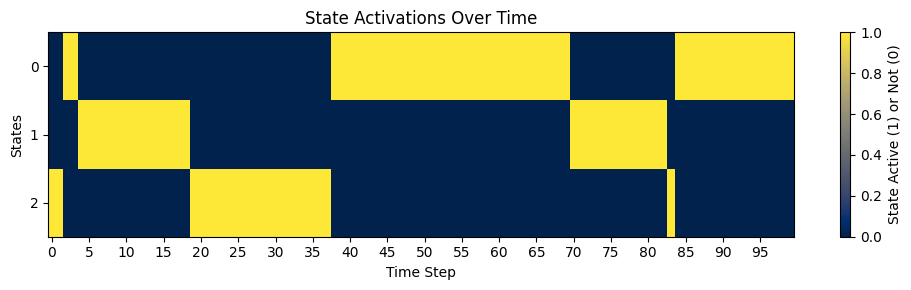

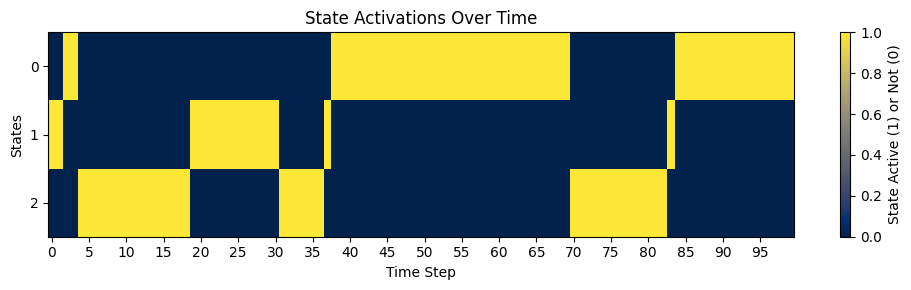

In [161]:
def plot_state_sequence(sequence, num_states=3):
    T = sequence.shape[0]
    
    # Create a binary matrix where each row corresponds to a state and each column corresponds to a time step
    activation_matrix = np.zeros((num_states, T))
    
    for t in range(T):
        activation_matrix[int(sequence[t]), t] = 1

    plt.figure(figsize=(10, num_states))
    plt.imshow(activation_matrix, aspect='auto', cmap='cividis')
    plt.yticks(np.arange(num_states))  # Show state numbers on the y-axis
    plt.xticks(np.arange(0, T, step=5))
    plt.xlabel("Time Step")
    plt.ylabel("States")
    plt.title("State Activations Over Time")
    plt.colorbar(label="State Active (1) or Not (0)")
    plt.tight_layout()
    plt.show()
    
plot_state_sequence(state_sample[:,:].flatten().to('cpu').numpy())
plot_state_sequence(predicted_states[:,:].flatten().to('cpu').numpy())
# plot_state_sequence(predicted_states1[:,:].flatten().to('cpu').numpy())

In [168]:
print(state_sample.shape)

torch.Size([1, 100])


In [175]:
# # Unique states
# states = torch.unique(torch.cat((state_sample.to(device), predicted_states.to(device))))
# print(states)

# # One-hot encoding
# def one_hot_encode(sequence, states):
#     one_hot = torch.zeros(len(states), len(sequence), dtype=torch.int32)
#     for i, s in enumerate(sequence):
#         # Find the index of state 's' in the list of unique states
#         state_idx = (states == s).nonzero(as_tuple=True)[0].item()
#         one_hot[state_idx, i] = 1
#     return one_hot

# actual_one_hot = torch.nn.functional.one_hot(state_sample.long)
# predicted_one_hot = torch.nn.functional.one_hot(predicted_states.long())

# # Compute the cost matrix (L1 norm difference between states)
# cost_matrix = np.zeros((len(states), len(states)))
# for i in range(len(states)):
#     for j in range(len(states)):
#         cost_matrix[i, j] = np.sum(np.abs(actual_one_hot[i] - predicted_one_hot[j]))

# # Apply Hungarian algorithm
# row_ind, col_ind = linear_sum_assignment(cost_matrix)

# # Get the optimal permutation of states
# optimal_permutation = col_ind

# print("Optimal permutation of states:", optimal_permutation)

# # Reorder B's states according to the optimal permutation
# predicted_states_permuted = predicted_states.clone()
# for i, j in enumerate(optimal_permutation):
#     predicted_states_permuted[predicted_states == states[j]] = states[i]

# print("Reordered B:", predicted_states_permuted)

tensor([0., 1., 2.], device='cuda:0')


TypeError: sum() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * (*, torch.dtype dtype)
      didn't match because some of the keywords were incorrect: out, axis
 * (tuple of ints dim, bool keepdim, *, torch.dtype dtype)
 * (tuple of names dim, bool keepdim, *, torch.dtype dtype)
